# <b><span style='color:#F1A424'>AutoML - Binary Classification - Titanic Survival Prediction </span> </b>

### Disclaimer
Please note, the Vantage Functions via SQLAlchemy feature is a preview/beta code release with limited functionality (the “Code”). As such, you acknowledge that the Code is experimental in nature and that the Code is provided “AS IS” and may not be functional on any machine or in any environment. TERADATA DISCLAIMS ALL WARRANTIES RELATING TO THE CODE, EXPRESS OR IMPLIED, INCLUDING, BUT NOT LIMITED TO, ANY WARRANTIES AGAINST INFRINGEMENT OF THIRD-PARTY RIGHTS, MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE.

TERADATA SHALL NOT BE RESPONSIBLE OR LIABLE WITH RESPECT TO ANY SUBJECT MATTER OF THE CODE UNDER ANY CONTRACT, NEGLIGENCE, STRICT LIABILITY OR OTHER THEORY 
    (A) FOR LOSS OR INACCURACY OF DATA OR COST OF PROCUREMENT OF SUBSTITUTE GOODS, SERVICES OR TECHNOLOGY, OR 
    (B) FOR ANY INDIRECT, INCIDENTAL OR CONSEQUENTIAL DAMAGES INCLUDING, BUT NOT LIMITED TO LOSS OF REVENUES AND LOSS OF PROFITS. TERADATA SHALL NOT BE RESPONSIBLE FOR ANY MATTER BEYOND ITS REASONABLE CONTROL.

Notwithstanding anything to the contrary: 
    (a) Teradata will have no obligation of any kind with respect to any Code-related comments, suggestions, design changes or improvements that you elect to provide to Teradata in either verbal or written form (collectively, “Feedback”), and 
    (b) Teradata and its affiliates are hereby free to use any ideas, concepts, know-how or techniques, in whole or in part, contained in Feedback: 
        (i) for any purpose whatsoever, including developing, manufacturing, and/or marketing products and/or services incorporating Feedback in whole or in part, and 
        (ii) without any restrictions or limitations, including requiring the payment of any license fees, royalties, or other consideration. 

## <b> Problem overview:</b>
    


The Titanic dataset is a well-known dataset in the field of machine learning and data science. It contains information about passengers aboard the RMS Titanic, including whether they survived or not. The dataset is often used for predictive modeling and classification tasks. Here are some key details about the Titanic dataset:

**Features**:

- `PassengerId`: Unique identifier for each passenger.
- `Pclass`: Ticket class (1st, 2nd, or 3rd).
- `Name`: Passenger's name.
- `Sex`: Passenger's gender (male or female).
- `Age`: Passenger's age.
- `SibSp`: Number of siblings or spouses aboard.
- `Parch`: Number of parents or children aboard.
- `Ticket`: Ticket number.
- `Fare`: Fare paid for the ticket.
- `Cabin`: Cabin number.
- `Embarked`: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

**Target Variable**:

- `Survived`: Binary variable indicating whether the passenger survived (1) or not (0).
        
**Objective**:

The main objective is typically to build a predictive model that can accurately predict whether a passenger survived based on the available features.

**Challenges**:

- Missing data in the columns such as `Age`, `Cabin`, and `Embarked`.
- Understanding passenger demographics and characteristics that influenced survival.(Model training)
- Exploring feature engineering techniques to improve model performance.(Feature engineering)

**Usecase**:

Here, we will use AutoML(Automated Machine Learning) functionality to automate the entire process of developing a predictive model. It will perform feature exploration, feature engineering, data preparation, model training and evaluation on dataset in custom run and at end we will get leaderboard containined different models along with their performance. Model will also have rank associated with them which indicates which is best performing model for given data followed by other models.

As part of custom AutoML run, we will customize below functionalities:
- Missing value handling for 'cabin', 'age' and 'embraked' with customized options i.e., 'delete', 'impute with median' and 'impute with mode' correspondingly.
- Binning on 'pclass' feature to get 2 different levels i.e., 'low' and 'high' based on values.
- Customized ordinal encoding on 'pclass' and target encoding on 'embracked'.
- Addition of 'parch' and 'sibsp' to get new feature 'Family_count'.
- Deletion of id column 'passanger' using antiselect.
- Train test split with training size 0.75.
- Data imbalance handling with 'SMOTE' method.
- Outlier filteration with 'percentile' method and customized lower-upper bound.
- Feature scaling with 'std' method.
- Addition of customized value in hyperparameter 'min_node_size' for 'xgboost' model.

In [1]:
# Importing AutoML from teradataml
from teradataml import AutoML, AutoClassifier

In [2]:
# Importing other important libraries

import getpass
from teradataml import create_context, remove_context
from teradataml import DataFrame
from teradataml import load_example_data
from teradataml import TrainTestSplit

In [3]:
# Create the connection.

host = getpass.getpass("Host: ")
username = getpass.getpass("Username: ")
password = getpass.getpass("Password: ")

con = create_context(host=host, username=username, password=password)

Host:  ········
Username:  ········
Password:  ········


## <b><span style='color:#F1A424'>| 1.</span> Loading Dataset </b>

In [4]:
# Loading titanic dataset from example data collection
load_example_data("teradataml", "titanic")

In [5]:
# Fetching in teradata dataframe
titanic = DataFrame.from_table("titanic")

In [6]:
titanic.columns

['passenger',
 'survived',
 'pclass',
 'name',
 'sex',
 'age',
 'sibsp',
 'parch',
 'ticket',
 'fare',
 'cabin',
 'embarked']

In [7]:
# titanic dataset
titanic.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S
6,0,3,"Moran, Mr. James",male,None,0,0,330877,8.4583,None,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,None,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,None,C
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,None,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S


In [8]:
# titanic dataset
titanic.shape

(891, 12)

In [9]:
# Performing sampling to get 80% for trainning and 20% for testing
titanic_sample = titanic.sample(frac = [0.8, 0.2])

In [10]:
titanic_sample.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,sampleid
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S,1
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S,1
6,0,3,"Moran, Mr. James",male,None,0,0,330877,8.4583,None,Q,1
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S,1
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,None,S,2
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,None,C,1
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,None,S,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C,1
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S,1


In [11]:
# Fetching train and test data
titanic_train= titanic_sample[titanic_sample['sampleid'] == 1].drop('sampleid', axis=1)
titanic_test = titanic_sample[titanic_sample['sampleid'] == 2].drop('sampleid', axis=1)

In [12]:
# train data shape
titanic_train.shape

(713, 12)

In [13]:
# test data shape
titanic_test.shape

(178, 12)

In [14]:
# train dataset
titanic_train.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
6,0,3,"Moran, Mr. James",male,None,0,0,330877,8.4583,None,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,None,C
12,1,1,"Bonnell, Miss. Elizabeth",female,58,0,0,113783,26.55,C103,S
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.05,None,S
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4,1,1,PP 9549,16.7,G6,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S


In [15]:
# test dataset
titanic_test.head()

passenger,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,None,S
19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)",female,31,1,0,345763,18.0,None,S
30,0,3,"Todoroff, Mr. Lalio",male,None,0,0,349216,7.8958,None,S
33,1,3,"Glynn, Miss. Mary Agatha",female,None,0,0,335677,7.75,None,Q
36,0,1,"Holverson, Mr. Alexander Oskar",male,42,1,0,113789,52.0,None,S
41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40,1,0,7546,9.475,None,S
35,0,1,"Meyer, Mr. Edgar Joseph",male,28,1,0,PC 17604,82.1708,None,C
18,1,2,"Williams, Mr. Charles Eugene",male,None,0,0,244373,13.0,None,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,None,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S


In [17]:
AutoML.generate_custom_config("custom_titanic")


Generating custom config JSON for AutoML ...

Available main options for customization with corresponding indices: 
--------------------------------------------------------------------------------

Index 1: Customize Feature Engineering Phase

Index 2: Customize Data Preparation Phase

Index 3: Customize Model Training Phase

Index 4: Generate custom json and exit
--------------------------------------------------------------------------------

Enter the index you want to customize:  1

Customizing Feature Engineering Phase ...

Available options for customization of feature engineering phase with corresponding indices: 
--------------------------------------------------------------------------------

Index 1: Customize Missing Value Handling

Index 2: Customize Bincode Encoding

Index 3: Customize String Manipulation

Index 4: Customize Categorical Encoding

Index 5: Customize Mathematical Transformation

Index 6: Customize Nonlinear Transformation

Index 7: Customize Antiselect Feat

## <b><span style='color:#F1A424'>| 2.</span> Fitting AutoML </b>

In [18]:
# Creating AutoML Instance with task type 'Classification'
# Including only decision forest and xgboost model from default model list for training.
# Using early stopping timer criteria with value 300 sec and max_models as 5
# Passing custom json file to provide customized value for AutoML.

aml = AutoML(task_type="Classification",
             include=['decision_forest','xgboost'],
             verbose=2,
             max_runtime_secs=300,
             max_models=5,
             custom_config_file='custom_titanic.json')


Received below input for customization : 
{
    "MissingValueHandlingIndicator": true,
    "MissingValueHandlingParam": {
        "DroppingColumnIndicator": true,
        "DroppingColumnList": [
            "cabin"
        ],
        "ImputeMissingIndicator": true,
        "StatImputeList": [
            "age",
            "embarked"
        ],
        "StatImputeMethod": [
            "median",
            "mode"
        ]
    },
    "BincodeIndicator": true,
    "BincodeParam": {
        "pclass": {
            "Type": "Variable-Width",
            "NumOfBins": 2,
            "Bin_1": {
                "min_value": 0,
                "max_value": 1,
                "label": "low"
            },
            "Bin_2": {
                "min_value": 2,
                "max_value": 3,
                "label": "high"
            }
        }
    },
    "CategoricalEncodingIndicator": true,
    "CategoricalEncodingParam": {
        "OrdinalEncodingIndicator": true,
        "OrdinalEncodingL

Feature Exploration started ...

Data Overview:
Total Rows in the data: 713
Total Columns in the data: 12

Column Summary:


ColumnName,Datatype,NonNullCount,NullCount,BlankCount,ZeroCount,PositiveCount,NegativeCount,NullPercentage,NonNullPercentage
age,INTEGER,567,146,None,4,563,0,20.47685834502104,79.52314165497896
fare,FLOAT,713,0,None,14,699,0,0.0,100.0
embarked,VARCHAR(20) CHARACTER SET LATIN,712,1,0,None,None,None,0.1402524544179523,99.85974754558205
sex,VARCHAR(20) CHARACTER SET LATIN,713,0,0,None,None,None,0.0,100.0
name,VARCHAR(1000) CHARACTER SET LATIN,713,0,0,None,None,None,0.0,100.0
passenger,INTEGER,713,0,None,0,713,0,0.0,100.0
cabin,VARCHAR(20) CHARACTER SET LATIN,170,543,0,None,None,None,76.15708274894811,23.842917251051894
sibsp,INTEGER,713,0,None,491,222,0,0.0,100.0
parch,INTEGER,713,0,None,548,165,0,0.0,100.0
ticket,VARCHAR(20) CHARACTER SET LATIN,713,0,0,None,None,None,0.0,100.0



Statistics of Data:


func,passenger,survived,pclass,age,sibsp,parch,fare
min,1,0,1,0,0,0,0
std,258.893,0.486,0.842,14.33,1.142,0.804,47.519
25%,219,0,2,20.5,0,0,7.896
50%,443,0,3,28,0,0,14.454
75%,670,1,3,38,1,0,31.275
max,891,1,3,80,8,5,512.329
mean,446.292,0.38,2.311,29.743,0.52,0.373,31.879
count,713,713,713,567,713,713,713



Categorical Columns with their Distinct values:
ColumnName                DistinctValueCount
name                      713       
sex                       2         
ticket                    568       
cabin                     135       
embarked                  3         

Futile columns in dataset:


ColumnName
name
ticket



Target Column Distribution:


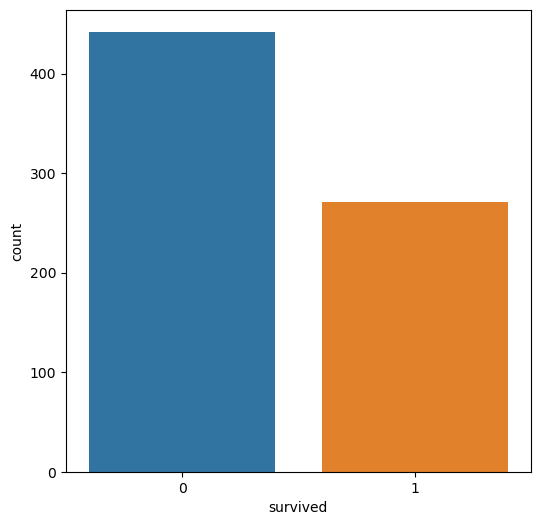

Columns with outlier percentage :-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  ColumnName  OutlierPercentage
0        age          21.458626
1      parch          23.141655
2       fare          13.323983
3      sibsp           5.049088


Analysis completed. No action taken.                                                    


['ticket', 'name']


passenger,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,id
40,1,3,female,14,1,0,11.2417,None,C,10
122,0,3,male,None,0,0,8.05,None,S,11
591,0,3,male,35,0,0,7.125,None,S,19
80,1,3,female,30,0,0,12.475,None,S,12
570,1,3,male,32,0,0,7.8542,None,S,15
835,0,3,male,18,0,0,8.3,None,S,23
265,0,3,female,None,0,0,7.75,None,Q,9
101,0,3,female,28,0,0,7.8958,None,S,17
326,1,1,female,36,0,0,135.6333,C32,C,13
305,0,3,male,None,0,0,8.05,None,S,21


Analysis Completed. Dataset does not contain any feature related to dates. No action needed.


['cabin']
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719264080855142"' - 3/20


passenger,survived,pclass,sex,age,sibsp,parch,fare,embarked,id
120,0,3,female,2,4,2,31.275,S,26
200,0,2,female,24,0,0,13.0,S,42
57,1,2,female,21,0,0,10.5,S,50
791,0,3,male,28,0,0,7.75,Q,58
158,0,3,male,30,0,0,8.05,S,74
688,0,3,male,19,0,0,10.1708,S,82
648,1,1,male,56,0,0,35.5,C,66
751,1,2,female,4,1,1,23.0,S,34
631,1,1,male,80,0,0,30.0,S,18
40,1,3,female,14,1,0,11.2417,C,10


Proceeding with default option for handling remaining missing values.                    


Analysis Completed. No Missing Values Detected.                                          


Analysis completed. No imputation required.                                              


No information provided for Equal-Width Transformation.                                  


,ColumnName,MinValue,MaxValue,Label
0,pclass,0,1,low
1,pclass,2,3,high


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719262539583496"' - 4/20


fare,sex,passenger,survived,parch,embarked,id,age,sibsp,pclass
31.3875,male,183,0,2,S,16,9,4,high
10.5,male,71,0,0,S,445,32,0,high
10.5,male,884,0,0,S,232,28,0,high
10.5,male,34,0,0,S,81,66,0,high
10.5,male,571,1,0,S,390,62,0,high
10.5,female,85,1,0,S,343,17,0,high
10.5,male,243,0,0,S,377,29,0,high
4.0125,male,379,0,0,C,164,20,0,high
31.3875,female,26,1,5,S,256,38,1,high
31.3875,male,262,1,2,S,499,3,4,high


Skipping customized string manipulation.⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾⫾｜ 25% - 5/20


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719264118745407"' - 6/20


fare,sex,passenger,survived,parch,embarked,id,age,sibsp,pclass
11.2417,male,126,1,0,C,632,12,1,0
69.55,male,160,0,2,S,86,28,8,0
69.55,male,325,0,2,S,370,28,8,0
69.55,female,864,0,2,S,639,28,8,0
69.55,female,181,0,2,S,78,28,8,0
69.55,female,793,0,2,S,79,28,8,0
69.55,male,847,0,2,S,595,28,8,0
11.2417,female,40,1,0,C,10,14,1,0
76.2917,female,219,1,0,C,80,32,0,1
40.125,male,584,0,0,C,413,36,0,1


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719265448540624"' - 6/20


embarked,fare,sex,passenger,survived,parch,id,age,sibsp,pclass
0.5428571428571428,78.2667,female,592,1,0,374,52,1,1
0.5428571428571428,27.7208,male,31,0,0,558,40,0,1
0.5428571428571428,27.7208,female,195,1,0,563,44,0,1
0.5428571428571428,27.7208,male,65,0,0,686,28,0,1
0.5428571428571428,18.7875,male,208,1,0,636,26,0,0
0.5428571428571428,18.7875,male,732,0,0,29,11,0,0
0.33267716535433073,69.55,female,864,0,2,639,28,8,0
0.33267716535433073,69.55,female,181,0,2,78,28,8,0
0.33267716535433073,69.55,female,793,0,2,79,28,8,0
0.33267716535433073,69.55,male,202,0,2,63,28,8,0


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719262683749148"' - 6/20


['sex']


embarked,fare,sex_0,sex_1,passenger,survived,parch,id,age,sibsp,pclass
0.5428571428571428,27.7208,1,0,195,1,0,563,44,0,1
0.5428571428571428,18.7875,0,1,208,1,0,636,26,0,0
0.5428571428571428,18.7875,0,1,732,0,0,29,11,0,0
0.5428571428571428,106.425,1,0,538,1,0,643,30,0,1
0.5428571428571428,146.5208,1,0,32,1,0,191,28,1,1
0.5428571428571428,146.5208,1,0,196,1,0,133,58,0,1
0.33267716535433073,69.55,1,0,793,0,2,79,28,8,0
0.33267716535433073,26.25,1,0,441,1,1,559,45,1,0
0.33267716535433073,26.25,1,0,238,1,2,118,8,0,0
0.33267716535433073,26.25,0,1,315,0,1,485,43,1,0


Skipping customized mathematical transformation.                                         


['Combination_1']
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719263762229876"' - 8/20


embarked,fare,sex_0,sex_1,passenger,survived,parch,id,age,sibsp,pclass,Family_count
0.5428571428571428,18.7875,0,1,732,0,0.0,29,11,0.0,0,1.0
0.5428571428571428,146.5208,1,0,32,1,0.0,191,28,1.0,1,2.0
0.5428571428571428,146.5208,1,0,196,1,0.0,133,58,0.0,1,1.0
0.5428571428571428,57.9792,1,0,330,1,1.0,702,16,0.0,1,2.0
0.5428571428571428,76.2917,1,0,219,1,0.0,80,32,0.0,1,1.0
0.5428571428571428,11.2417,0,1,126,1,0.0,632,12,1.0,0,2.0
0.38235294117647056,7.75,1,0,265,0,0.0,9,28,0.0,0,1.0
0.38235294117647056,7.75,1,0,768,0,0.0,155,30,0.0,0,1.0
0.38235294117647056,7.75,1,0,209,1,0.0,299,16,0.0,0,1.0
0.38235294117647056,7.75,0,1,777,0,0.0,340,28,0.0,0,1.0


embarked,fare,sex_0,sex_1,survived,parch,id,age,sibsp,pclass,Family_count
0.5428571428571428,18.7875,0,1,0,0.0,29,11,0.0,0,1.0
0.5428571428571428,146.5208,1,0,1,0.0,191,28,1.0,1,2.0
0.5428571428571428,146.5208,1,0,1,0.0,133,58,0.0,1,1.0
0.5428571428571428,57.9792,1,0,1,1.0,702,16,0.0,1,2.0
0.5428571428571428,76.2917,1,0,1,0.0,80,32,0.0,1,1.0
0.5428571428571428,11.2417,0,1,1,0.0,632,12,1.0,0,2.0
0.38235294117647056,7.75,1,0,0,0.0,9,28,0.0,0,1.0
0.38235294117647056,7.75,1,0,0,0.0,155,30,0.0,0,1.0
0.38235294117647056,7.75,1,0,1,0.0,299,16,0.0,0,1.0
0.38235294117647056,7.75,0,1,0,0.0,340,28,0.0,0,1.0


Training size : 0.75                                                                      
Testing size  : 0.25                                                                      


embarked,fare,sex_0,sex_1,survived,parch,id,age,sibsp,pclass,Family_count
0.5428571428571428,29.7,0,1,0,0.0,46,58,0.0,1,1.0
0.5428571428571428,49.5042,1,0,1,0.0,61,24,0.0,1,1.0
0.5428571428571428,35.5,0,1,1,0.0,66,56,0.0,1,1.0
0.5428571428571428,76.2917,1,0,1,0.0,80,32,0.0,1,1.0
0.5428571428571428,7.2292,0,1,0,0.0,95,28,0.0,0,1.0
0.5428571428571428,57.9792,1,0,1,1.0,96,44,0.0,1,2.0
0.38235294117647056,7.725,0,1,0,0.0,8,28,0.0,0,1.0
0.38235294117647056,29.125,0,1,0,1.0,33,2,4.0,0,6.0
0.38235294117647056,7.75,0,1,0,0.0,57,28,0.0,0,1.0
0.38235294117647056,7.75,1,0,1,0.0,65,28,0.0,0,1.0


embarked,fare,sex_0,sex_1,survived,parch,id,age,sibsp,pclass,Family_count
0.33267716535433073,7.8958,1,0,0,0.0,17,28,0.0,0,1.0
0.33267716535433073,23.0,1,0,1,1.0,38,18,0.0,0,2.0
0.33267716535433073,7.05,0,1,0,0.0,40,35,0.0,0,1.0
0.33267716535433073,30.5,0,1,1,0.0,41,27,0.0,1,1.0
0.33267716535433073,13.0,1,0,1,0.0,69,28,0.0,0,1.0
0.33267716535433073,39.4,1,0,1,1.0,75,16,0.0,1,2.0
0.5428571428571428,135.6333,1,0,1,0.0,13,36,0.0,1,1.0
0.5428571428571428,7.2292,0,1,0,0.0,22,22,0.0,0,1.0
0.5428571428571428,15.2458,1,0,0,2.0,54,28,0.0,0,3.0
0.5428571428571428,227.525,1,0,1,0.0,104,42,0.0,1,1.0


Columns with outlier percentage :-                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
     ColumnName  OutlierPercentage
0  Family_count           3.085554
1         parch           1.823282
2         sibsp           3.646564
3            id           9.817672
4           age           9.396914
5          fare           9.817672
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719263471570825"'
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719262762668453"' - 12/20
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719268428917289

['fare', 'Family_count', 'parch', 'embarked', 'age', 'sibsp', 'sex_1', 'pclass', 'sex_0']


['fare', 'Family_count', 'parch', 'embarked', 'age', 'sibsp', 'pclass']


sex_1,sex_0,survived,id,fare,Family_count,parch,embarked,age,sibsp,pclass
1,0,0,11,-0.6922923344706197,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.12528818299862196,-0.4478850877632824,-0.5845584168528979
1,0,0,16,0.2982075421458125,3.178413441047677,2.0804752327827103,-0.5590422730432916,-1.5747453149302288,3.135195614342977,-0.5845584168528979
1,0,1,18,0.23931869034912054,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,3.841647125445776,-0.4478850877632824,1.7106930140253924
1,0,0,19,-0.420482615784944,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,0.40872233929197005,-0.4478850877632824,-0.5845584168528979
1,0,0,21,-0.6922923344706197,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.12528818299862196,-0.4478850877632824,-0.5845584168528979
1,0,0,23,-0.6816817305432877,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.8881603576994678,-0.4478850877632824,-0.5845584168528979
1,0,0,20,-0.48220237670944816,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,0.48500955676205465,-0.4478850877632824,-0.5845584168528979
1,0,1,15,-0.7006025594665061,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,0.17986068688171633,-0.4478850877632824,-0.5845584168528979
0,1,1,10,-0.5568288762511588,0.08571523128189792,-0.4588933942023578,1.9797761767306754,-1.193309227579806,0.4478850877632824,-0.5845584168528979
1,0,0,8,-0.7060861195761512,-0.5328244106712579,-0.4588933942023578,0.0412397295911812,-0.12528818299862196,-0.4478850877632824,-0.5845584168528979


sex_1,sex_0,survived,id,fare,Family_count,parch,embarked,age,sibsp,pclass
1,0,1,167,2.2226188225134305,0.08571523128189792,-0.4588933942023578,1.9797761767306754,1.4004561664030695,0.4478850877632824,1.7106930140253924
0,1,1,225,3.773710858543374,0.08571523128189792,-0.4588933942023578,1.9797761767306754,-0.5067242703490449,0.4478850877632824,1.7106930140253924
1,0,0,86,1.9179162316530258,5.652572008860299,2.0804752327827103,-0.5590422730432916,-0.12528818299862196,6.718276316449236,-0.5845584168528979
0,1,1,265,1.4871257122033512,0.08571523128189792,-0.4588933942023578,1.9797761767306754,1.858179471223577,0.4478850877632824,1.7106930140253924
1,0,1,357,2.831667487942281,0.08571523128189792,-0.4588933942023578,1.9797761767306754,-0.3541498354088757,0.4478850877632824,1.7106930140253924
0,1,0,122,0.2934327703785131,3.178413441047677,2.0804752327827103,-0.5590422730432916,-1.4221708799900599,3.135195614342977,-0.5845584168528979
1,0,0,94,-0.6988369549729979,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.27786261793879113,-0.4478850877632824,-0.5845584168528979
1,0,0,81,-0.5883084159827671,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,2.773626080864592,-0.4478850877632824,-0.5845584168528979
1,0,0,27,0.9565955158367565,3.7969530830008327,2.0804752327827103,-0.5590422730432916,-2.1850430546909054,4.0309657898695415,-0.5845584168528979
0,1,1,159,4.6745511319738515,0.7042548732350536,0.8107909192901762,1.9797761767306754,0.790158426642393,0.4478850877632824,1.7106930140253924


['age', 'sex_1', 'pclass', 'sex_0', 'fare', 'Family_count']


['r_age', 'r_pclass', 'r_fare', 'r_Family_count']


r_sex_1,survived,r_sex_0,id,r_age,r_pclass,r_fare,r_Family_count
1,0,0,11,-0.12528818299862196,-0.5845584168528979,-0.6922923344706197,-0.5328244106712579
1,0,0,16,-1.5747453149302288,-0.5845584168528979,0.2982075421458125,3.178413441047677
1,1,0,18,3.841647125445776,1.7106930140253924,0.23931869034912054,-0.5328244106712579
1,0,0,19,0.40872233929197005,-0.5845584168528979,-0.420482615784944,-0.5328244106712579
1,0,0,21,-0.12528818299862196,-0.5845584168528979,-0.6922923344706197,-0.5328244106712579
1,0,0,23,-0.8881603576994678,-0.5845584168528979,-0.6816817305432877,-0.5328244106712579
1,0,0,20,0.48500955676205465,-0.5845584168528979,-0.48220237670944816,-0.5328244106712579
1,1,0,15,0.17986068688171633,-0.5845584168528979,-0.7006025594665061,-0.5328244106712579
0,1,1,10,-1.193309227579806,-0.5845584168528979,-0.5568288762511588,0.08571523128189792
1,0,0,8,-0.12528818299862196,-0.5845584168528979,-0.7060861195761512,-0.5328244106712579


r_sex_1,survived,r_sex_0,id,r_age,r_pclass,r_fare,r_Family_count
1,1,0,167,1.4004561664030695,1.7106930140253924,2.2226188225134305,0.08571523128189792
0,1,1,225,-0.5067242703490449,1.7106930140253924,3.773710858543374,0.08571523128189792
1,0,0,86,-0.12528818299862196,-0.5845584168528979,1.9179162316530258,5.652572008860299
0,1,1,265,1.858179471223577,1.7106930140253924,1.4871257122033512,0.08571523128189792
1,1,0,357,-0.3541498354088757,1.7106930140253924,2.831667487942281,0.08571523128189792
0,0,1,122,-1.4221708799900599,-0.5845584168528979,0.2934327703785131,3.178413441047677
1,0,0,94,-0.27786261793879113,-0.5845584168528979,-0.6988369549729979,-0.5328244106712579
1,0,0,81,2.773626080864592,-0.5845584168528979,-0.5883084159827671,-0.5328244106712579
1,0,0,27,-2.1850430546909054,-0.5845584168528979,0.9565955158367565,3.7969530830008327
0,1,1,159,0.790158426642393,1.7106930140253924,4.6745511319738515,0.7042548732350536


['embarked', 'fare', 'parch', 'age', 'sibsp', 'pclass', 'Family_count']


sex_1,sex_0,survived,id,embarked,fare,parch,age,sibsp,pclass,Family_count
1,0,1,66,1.9797995386187863,0.4727519767504224,-0.45889339420235703,2.0107539061637403,-0.4478850877632818,1.7106930140253955,-0.5328244106712589
1,0,0,95,1.9797995386187863,-0.7271290692848361,-0.45889339420235703,-0.12528818299862163,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
0,1,1,96,1.9797995386187863,1.4268235279635393,0.8107909192901749,1.0953072965227282,-0.4478850877632818,1.7106930140253955,0.08571523128189808
1,0,0,100,1.9797995386187863,0.14258393646442125,-0.45889339420235703,-0.049000965528537256,0.4478850877632818,-0.5845584168528989,0.08571523128189808
1,0,0,106,1.9797995386187863,0.7307679103305668,2.0804752327827067,-0.3541498354088747,0.4478850877632818,-0.5845584168528989,1.322794515188212
1,0,0,110,1.9797995386187863,-0.6641742340631904,-0.45889339420235703,-0.12528818299862163,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
1,0,0,16,-0.5590211670991129,0.2982075421458127,2.0804752327827067,-1.5747453149302244,3.1351956143429724,-0.5845584168528989,3.1784134410476828
1,0,0,19,-0.5590211670991129,-0.4204826157849442,-0.45889339420235703,0.4087223392919689,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
1,0,0,20,-0.5590211670991129,-0.4822023767094484,-0.45889339420235703,0.48500955676205326,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
1,0,0,21,-0.5590211670991129,-0.69229233447062,-0.45889339420235703,-0.12528818299862163,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589


sex_1,sex_0,survived,id,embarked,fare,parch,age,sibsp,pclass,Family_count
0,1,0,54,1.9797995386187863,-0.3868851995094405,2.0804752327827067,-0.12528818299862163,-0.4478850877632818,-0.5845584168528989,0.704254873235055
1,0,0,146,1.9797995386187863,0.2688501231996707,-0.45889339420235703,2.0107539061637403,-0.4478850877632818,1.7106930140253955,-0.5328244106712589
0,1,1,159,1.9797995386187863,4.674551131973854,0.8107909192901749,0.7901584266423907,0.4478850877632818,1.7106930140253955,0.704254873235055
0,1,1,160,1.9797995386187863,-0.4457740513061325,-0.45889339420235703,-0.20157540046870598,0.4478850877632818,-0.5845584168528989,0.08571523128189808
0,1,1,225,1.9797995386187863,3.773710858543376,-0.45889339420235703,-0.5067242703490434,0.4478850877632818,1.7106930140253955,0.08571523128189808
0,1,1,265,1.9797995386187863,1.4871257122033519,-0.45889339420235703,1.8581794712235717,0.4478850877632818,1.7106930140253955,0.08571523128189808
0,1,1,12,-0.5590211670991129,-0.5044846449568454,-0.45889339420235703,0.0272862519415471,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
1,0,0,14,-0.5590211670991129,-0.4822023767094484,-0.45889339420235703,-0.5067242703490434,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
0,1,0,17,-0.5590211670991129,-0.6988369549729982,-0.45889339420235703,-0.12528818299862163,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
1,0,0,27,-0.5590211670991129,0.956595515836757,2.0804752327827067,-2.185043054690899,4.030965789869536,-0.5845584168528989,3.7969530830008393


['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5']


                                                                                          
Completed customized hyperparameter update.


response_column : survived                                                                                                                            
name : decision_forest
tree_type : Classification
min_impurity : (0.0, 0.1, 0.2)
max_depth : (5, 6, 8, 10)
min_node_size : (1, 2, 3)
num_trees : (-1, 20, 30)
seed : 42
Total number of models for decision_forest : 108
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

response_column : survived
name : xgboost
model_type : Classification
column_sampling : (1, 0.6)
min_impurity : (0.0, 0.1, 0.2)
lambda1 : (0.01, 0.1, 1, 10)
shrinkage_factor : (0.5, 0.1, 0.3)
max_depth : (5, 6, 8, 10)
min_node_size : (1, 2, 3, 5)
iter_num : (10, 20, 30)
seed : 42
Total number of models for xgboost : 3456
-----------------------------------------------------------------------------------------------------------

result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719264026547136"'                                                                                                                      
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719262914959595"'
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719264311636111"'


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719263046520320"'                                                                                                                      
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719264356366180"'
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719263957214003"'


,Rank,Model-ID,Feature-Selection,Accuracy,Micro-Precision,Micro-Recall,Micro-F1,Macro-Precision,Macro-Recall,Macro-F1,Weighted-Precision,Weighted-Recall,Weighted-F1
0,1,DECISIONFOREST_2,pca,0.804469,0.804469,0.804469,0.804469,0.793590,0.788222,0.790643,0.803137,0.804469,0.803568
1,2,DECISIONFOREST_0,lasso,0.798883,0.798883,0.798883,0.798883,0.789289,0.778021,0.782591,0.796789,0.798883,0.796888
2,3,XGBOOST_2,pca,0.793296,0.793296,0.793296,0.793296,0.782499,0.773516,0.777281,0.791259,0.793296,0.791628
3,4,XGBOOST_0,lasso,0.748603,0.748603,0.748603,0.748603,0.771603,0.689057,0.696781,0.762184,0.748603,0.726894
4,5,DECISIONFOREST_1,rfe,0.715084,0.715084,0.715084,0.715084,0.716117,0.656333,0.660089,0.715677,0.715084,0.692933


In [19]:
# Fitting train data
aml.fit(titanic_train, titanic_train.survived)

## <b><span style='color:#F1A424'>| 3.</span> Leaderboard : </b>

In [20]:
# Fetching Leaderboard
aml.leaderboard()

,Rank,Model-ID,Feature-Selection,Accuracy,Micro-Precision,Micro-Recall,Micro-F1,Macro-Precision,Macro-Recall,Macro-F1,Weighted-Precision,Weighted-Recall,Weighted-F1
0,1,DECISIONFOREST_2,pca,0.804469,0.804469,0.804469,0.804469,0.793590,0.788222,0.790643,0.803137,0.804469,0.803568
1,2,DECISIONFOREST_0,lasso,0.798883,0.798883,0.798883,0.798883,0.789289,0.778021,0.782591,0.796789,0.798883,0.796888
2,3,XGBOOST_2,pca,0.793296,0.793296,0.793296,0.793296,0.782499,0.773516,0.777281,0.791259,0.793296,0.791628
3,4,XGBOOST_0,lasso,0.748603,0.748603,0.748603,0.748603,0.771603,0.689057,0.696781,0.762184,0.748603,0.726894
4,5,DECISIONFOREST_1,rfe,0.715084,0.715084,0.715084,0.715084,0.716117,0.656333,0.660089,0.715677,0.715084,0.692933


## <b><span style='color:#F1A424'>| 4.</span> Best Performing Model : </b>

In [21]:
# Fetching best performing model for dataset
aml.leader()

,Rank,Model-ID,Feature-Selection,Accuracy,Micro-Precision,Micro-Recall,Micro-F1,Macro-Precision,Macro-Recall,Macro-F1,Weighted-Precision,Weighted-Recall,Weighted-F1
0,1,DECISIONFOREST_2,pca,0.804469,0.804469,0.804469,0.804469,0.79359,0.788222,0.790643,0.803137,0.804469,0.803568


## <b><span style='color:#F1A424'>| 5.</span> Generating Prediction : </b>

In [24]:
# Generating prediction and metrics on test data
prediction = aml.predict(titanic_test)

Data Transformation started ...


passenger,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,id
530,0,2,male,23,2,1,11.5,None,S,9
448,1,1,male,34,0,0,26.55,None,S,11
19,0,3,female,31,1,0,18.0,None,S,19
505,1,1,female,16,0,0,86.5,B79,S,12
753,0,3,male,33,0,0,9.5,None,S,15
671,1,2,female,40,1,1,39.0,None,S,23
383,0,3,male,32,0,0,7.925,None,S,10
831,1,3,female,15,1,0,14.4542,None,C,18
99,1,2,female,34,0,1,23.0,None,S,13
709,1,1,female,22,0,0,151.55,None,S,21


fare,sex,passenger,parch,embarked,id,age,sibsp,cabin,pclass,survived
26.55,male,448,0,S,11,34,0,None,1,1
7.225,male,774,0,C,8,None,0,None,3,0
7.25,male,366,0,S,16,30,0,None,3,0
23.0,female,99,1,S,13,34,0,None,2,1
7.125,male,244,0,S,14,22,0,None,3,0
24.0,female,875,0,C,22,28,1,None,2,1
11.5,male,530,1,S,9,23,2,None,2,0
8.05,male,284,0,S,17,19,0,None,3,1
86.5,female,505,0,S,12,16,0,B79,1,1
512.3292,female,259,0,C,20,35,0,None,1,1


fare,sex,passenger,parch,embarked,id,age,sibsp,pclass,survived
86.5,female,505,0,S,12,16,0,1,1
23.0,female,99,1,S,13,34,0,2,1
151.55,female,709,0,S,21,22,0,1,1
7.225,male,774,0,C,8,None,0,3,0
11.5,male,530,1,S,9,23,2,2,0
8.05,male,284,0,S,17,19,0,3,1
7.125,male,244,0,S,14,22,0,3,0
24.0,female,875,0,C,22,28,1,2,1
7.925,male,383,0,S,10,32,0,3,0
14.4542,female,831,0,C,18,15,1,3,1


fare,sex,passenger,parch,embarked,id,age,sibsp,pclass,survived
26.55,male,448,0,S,11,34,0,1,1
9.5,male,753,0,S,15,33,0,3,0
39.0,female,671,1,S,23,40,1,2,1
23.0,female,99,1,S,13,34,0,2,1
7.925,male,383,0,S,10,32,0,3,0
14.4542,female,831,0,C,18,15,1,3,1
86.5,female,505,0,S,12,16,0,1,1
512.3292,female,259,0,C,20,35,0,1,1
7.125,male,244,0,S,14,22,0,3,0
24.0,female,875,0,C,22,28,1,2,1


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719263345787569"'⫾⫾⫾｜ 33% - 5/15


fare,sex,passenger,parch,embarked,id,survived,age,sibsp,pclass
7.2292,male,525,0,C,114,0,28,0,high
7.925,male,393,0,S,172,0,28,2,high
7.925,male,745,0,S,53,1,31,0,high
7.925,male,383,0,S,10,0,32,0,high
7.925,male,580,0,S,126,1,32,0,high
7.925,male,841,0,S,195,0,20,0,high
7.925,male,174,0,S,191,0,21,0,high
13.8625,male,548,0,C,74,1,28,0,high
7.2292,male,297,0,C,63,0,23,0,high
7.2292,male,532,0,C,153,0,28,0,high


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719263382743276"'⫾⫾⫾｜ 46% - 7/15
result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719264872092877"'


embarked,fare,sex,passenger,parch,id,survived,age,sibsp,pclass
0.5428571428571428,14.4542,female,831,0,18,1,15,1,0
0.5428571428571428,110.8833,female,307,0,170,1,28,0,1
0.5428571428571428,110.8833,female,582,1,163,1,39,1,1
0.5428571428571428,15.7417,female,382,2,116,1,1,0,0
0.5428571428571428,24.0,female,875,0,22,1,28,1,0
0.5428571428571428,19.2583,female,470,1,100,1,0,2,0
0.38235294117647056,8.1375,female,681,0,138,0,28,0,0
0.38235294117647056,6.75,male,144,0,91,0,19,0,0
0.38235294117647056,7.75,female,33,0,97,1,28,0,0
0.38235294117647056,7.75,male,561,0,148,0,28,0,0


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719264295526161"'⫾⫾⫾｜ 46% - 7/15


embarked,fare,sex_0,sex_1,passenger,parch,id,survived,age,sibsp,pclass
0.5428571428571428,110.8833,1,0,582,1,163,1,39,1,1
0.5428571428571428,24.0,1,0,875,0,22,1,28,1,0
0.5428571428571428,19.2583,1,0,470,1,100,1,0,2,0
0.5428571428571428,113.275,0,1,660,2,171,0,58,0,1
0.5428571428571428,7.8958,0,1,848,0,34,0,35,0,0
0.5428571428571428,13.7917,1,0,474,0,103,1,23,0,0
0.33267716535433073,7.925,0,1,393,0,172,0,28,2,0
0.33267716535433073,25.9292,1,0,863,0,66,1,48,0,1
0.33267716535433073,25.9292,1,0,797,0,176,1,49,0,1
0.33267716535433073,29.0,0,1,79,2,151,1,0,0,0


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719269624581290"'⫾⫾⫾｜ 60% - 9/15


embarked,fare,sex_0,sex_1,passenger,parch,id,survived,age,sibsp,pclass,Family_count
0.38235294117647056,15.5,1,0,658,1.0,180,0,32,1.0,0,3.0
0.38235294117647056,6.75,0,1,144,0.0,91,0,19,0.0,0,1.0
0.38235294117647056,8.1375,1,0,681,0.0,138,0,28,0.0,0,1.0
0.38235294117647056,7.75,0,1,561,0.0,148,0,28,0.0,0,1.0
0.38235294117647056,12.35,0,1,627,0.0,33,0,57,0.0,0,1.0
0.38235294117647056,7.75,1,0,33,0.0,97,1,28,0.0,0,1.0
0.5428571428571428,110.8833,1,0,582,1.0,163,1,39,1.0,1,3.0
0.5428571428571428,24.0,1,0,875,0.0,22,1,28,1.0,0,2.0
0.5428571428571428,19.2583,1,0,470,1.0,100,1,0,2.0,0,4.0
0.5428571428571428,113.275,0,1,660,2.0,171,0,58,0.0,1,3.0


embarked,fare,sex_0,sex_1,parch,id,survived,age,sibsp,pclass,Family_count
0.33267716535433073,7.8542,1,0,0.0,199,1,19,1.0,0,2.0
0.33267716535433073,65.0,1,0,2.0,158,1,24,1.0,0,4.0
0.33267716535433073,7.125,0,1,0.0,14,0,22,0.0,0,1.0
0.33267716535433073,7.875,0,1,0.0,26,0,29,0.0,0,1.0
0.33267716535433073,8.1125,0,1,0.0,123,1,28,0.0,0,1.0
0.33267716535433073,211.3375,1,0,0.0,115,1,29,0.0,1,1.0
0.5428571428571428,110.8833,1,0,1.0,163,1,39,1.0,1,3.0
0.5428571428571428,24.0,1,0,0.0,22,1,28,1.0,0,2.0
0.5428571428571428,19.2583,1,0,1.0,100,1,0,2.0,0,4.0
0.5428571428571428,113.275,0,1,2.0,171,0,58,0.0,1,3.0


result data stored in table '"ALICE"."ml__td_sqlmr_persist_out__1719263099898003"'⫾⫾⫾｜ 73% - 11/15


id,fare,Family_count,parch,embarked,age,sibsp,sex_1,pclass,sex_0,survived
128,9.825,2.0,0.0,0.3327,21,1.0,0,0,1,0
140,71.0,3.0,1.0,0.3327,70,1.0,1,1,0,0
62,39.6875,6.0,1.0,0.3327,2,4.0,1,0,0,0
188,7.7958,1.0,0.0,0.3327,28,0.0,1,0,0,0
83,8.05,1.0,0.0,0.3327,28,0.0,1,0,0,0
93,8.05,1.0,0.0,0.3327,19,0.0,1,0,0,0
158,65.0,4.0,2.0,0.3327,24,1.0,0,0,1,1
123,8.1125,1.0,0.0,0.3327,28,0.0,1,0,0,1
115,211.3375,1.0,0.0,0.3327,29,0.0,0,1,1,1
127,19.5,2.0,1.0,0.3327,13,0.0,0,0,1,1


sex_1,sex_0,survived,id,fare,Family_count,parch,embarked,age,sibsp,pclass
0,1,0,128,-0.6169570465865633,0.08571523128189792,-0.4588933942023578,-0.5590422730432916,-0.659298705289214,0.4478850877632824,-0.5845584168528979
1,0,0,140,1.979457734431551,0.7042548732350536,0.8107909192901762,-0.5590422730432916,3.0787749507449305,0.4478850877632824,1.7106930140253924
1,0,0,62,0.6504795925332314,2.5598737990945213,0.8107909192901762,-0.5590422730432916,-2.108755837220821,3.135195614342977,-0.5845584168528979
1,0,0,188,-0.7030811965439308,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.12528818299862196,-0.4478850877632824,-0.5845584168528979
1,0,0,83,-0.6922923344706197,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.12528818299862196,-0.4478850877632824,-0.5845584168528979
1,0,0,93,-0.6922923344706197,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.8118731402293832,-0.4478850877632824,-0.5845584168528979
0,1,1,158,1.7248032401755855,1.3227945151882097,2.0804752327827103,-0.5590422730432916,-0.4304370528789603,0.4478850877632824,-0.5845584168528979
1,0,1,123,-0.6896396834887867,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.12528818299862196,-0.4478850877632824,-0.5845584168528979
0,1,1,115,7.935720249039309,-0.5328244106712579,-0.4588933942023578,-0.5590422730432916,-0.049000965528537395,-0.4478850877632824,1.7106930140253924
0,1,1,127,-0.20632667459881895,0.08571523128189792,0.8107909192901762,-0.5590422730432916,-1.2695964450498907,-0.4478850877632824,-0.5845584168528979


id,age,sex_1,pclass,sex_0,fare,Family_count,survived
115,29,0,1,1,211.3375,1.0,1
143,35,0,1,1,90.0,2.0,1
175,62,0,1,1,80.0,1.0,1
17,19,1,0,0,8.05,1.0,1
147,30,0,0,1,13.0,1.0,1
182,36,0,0,1,13.0,1.0,1
14,22,1,0,0,7.125,1.0,0
183,28,0,0,1,23.45,4.0,0
128,21,0,0,1,9.825,2.0,0
44,20,0,0,1,9.825,2.0,0


r_sex_1,survived,r_sex_0,id,r_age,r_pclass,r_fare,r_Family_count
0,1,1,115,-0.049000965528537395,1.7106930140253924,7.935720249039309,-0.5328244106712579
0,1,1,143,0.40872233929197005,1.7106930140253924,2.7858636329087747,0.08571523128189792
0,1,1,175,2.4684772109842537,1.7106930140253924,2.361439475815499,-0.5328244106712579
1,1,0,17,-0.8118731402293832,-0.5845584168528979,-0.6922923344706197,-0.5328244106712579
0,1,1,147,0.02728625194154718,-0.5845584168528979,-0.48220237670944816,-0.5328244106712579
0,1,1,182,0.48500955676205465,-0.5845584168528979,-0.48220237670944816,-0.5328244106712579
1,0,0,14,-0.5830114878191295,-0.5845584168528979,-0.7315515690017477,-0.5328244106712579
0,0,1,183,-0.12528818299862196,-0.5845584168528979,-0.038679132546975074,1.3227945151882097
0,0,1,128,-0.659298705289214,-0.5845584168528979,-0.6169570465865633,0.08571523128189792
0,0,1,44,-0.7355859227592986,-0.5845584168528979,-0.6169570465865633,0.08571523128189792


sex_1,sex_0,survived,id,embarked,fare,parch,age,sibsp,pclass,Family_count
0,1,1,115,-0.5587453412477561,7.935720249039313,-0.45889339420235703,-0.049000965528537256,-0.4478850877632818,1.7106930140253955,-0.5328244106712589
0,1,1,143,-0.5587453412477561,2.785863632908776,-0.45889339420235703,0.4087223392919689,0.4478850877632818,1.7106930140253955,0.08571523128189808
0,1,1,175,-0.5587453412477561,2.3614394758155,-0.45889339420235703,2.4684772109842466,-0.4478850877632818,1.7106930140253955,-0.5328244106712589
1,0,1,17,-0.5587453412477561,-0.69229233447062,-0.45889339420235703,-0.8118731402293808,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
0,1,1,147,-0.5587453412477561,-0.4822023767094484,-0.45889339420235703,0.0272862519415471,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
0,1,1,182,-0.5587453412477561,-0.4822023767094484,-0.45889339420235703,0.48500955676205326,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
1,0,0,14,-0.5587453412477561,-0.731551569001748,-0.45889339420235703,-0.5830114878191278,-0.4478850877632818,-0.5845584168528989,-0.5328244106712589
0,1,0,183,-0.5587453412477561,-0.038679132546975095,2.0804752327827067,-0.12528818299862163,0.4478850877632818,-0.5845584168528989,1.322794515188212
0,1,0,128,-0.5587453412477561,-0.6169570465865635,-0.45889339420235703,-0.6592987052892121,0.4478850877632818,-0.5845584168528989,0.08571523128189808
0,1,0,44,-0.5587453412477561,-0.6169570465865635,-0.45889339420235703,-0.7355859227592965,0.4478850877632818,-0.5845584168528989,0.08571523128189808


,id,col_0,col_1,col_2,col_3,col_4,col_5,survived
0,158,2.677226,-0.060338,-0.254735,-0.118161,1.309002,-0.473388,1
1,14,-0.947702,-1.116770,-0.025885,-0.435016,-0.040591,0.321686,0
2,123,-1.018201,-0.915846,-0.286417,-0.140317,-0.097266,0.263621,1
3,183,2.109187,-0.881445,-0.297899,0.767697,1.307511,-0.460878,0
4,115,1.705025,5.282561,-0.894697,-3.997295,0.631098,-0.924255,1
5,128,0.067772,-1.104496,0.096949,-0.424900,-0.153829,-1.108418,0
6,127,0.437777,-1.168874,0.507865,-0.554403,1.272972,-0.544967,1
7,44,0.081553,-1.134259,0.139862,-0.476705,-0.144525,-1.098940,0
8,143,0.969011,2.614011,-0.900646,-1.621358,0.088011,-0.968041,1
9,140,1.113123,2.996467,-2.581972,1.005660,0.076419,0.390650,0


Data Transformation completed.⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿⫿｜ 100% - 15/15            

Following model is being used for generating prediction :
Model ID : DECISIONFOREST_2 
Feature Selection Method : pca

Prediction : 
    id  prediction  prob  survived
0  123           0   1.0         1
1  115           1   1.0         1
2  128           0   1.0         0
3  127           1   1.0         1
4  143           1   1.0         1
5  140           0   1.0         0
6   44           0   1.0         0
7  183           0   1.0         0
8   14           0   1.0         0
9  158           1   1.0         1

Performance Metrics : 
       Prediction  Mapping  CLASS_1  CLASS_2  Precision   Recall        F1  Support
SeqNum                                                                             
0               0  CLASS_1       95       20   0.826087  0.88785  0.855856      107
1               1  CLASS_2       12       51   0.809524  0.71831  0.761194       71

ROC-AUC : 


AUC,GINI
0.7628011056996182,0.5256022113992365


threshold_value,tpr,fpr
0.04081632653061224,0.7183098591549296,0.11214953271028037
0.08163265306122448,0.7183098591549296,0.11214953271028037
0.1020408163265306,0.7183098591549296,0.11214953271028037
0.12244897959183673,0.7183098591549296,0.11214953271028037
0.16326530612244897,0.7183098591549296,0.11214953271028037
0.18367346938775508,0.7183098591549296,0.11214953271028037
0.14285714285714285,0.7183098591549296,0.11214953271028037
0.061224489795918366,0.7183098591549296,0.11214953271028037
0.02040816326530612,0.7183098591549296,0.11214953271028037
0.0,1.0,1.0



Confusion Matrix : 


array([[95, 12],
       [20, 51]], dtype=int64)

In [25]:
# Printing prediction
prediction.head()

id,prediction,prob,survived
10,0,1.0,0
12,1,1.0,1
13,1,1.0,1
14,0,1.0,0
16,0,1.0,0
17,0,1.0,1
15,0,1.0,0
11,0,1.0,1
9,0,1.0,0
8,0,1.0,0


In [26]:
remove_context()

True